In [374]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [375]:
def concat_df(df_train, df_test, time_col='time', time_split='2024-10-30'):
    df_train = df_train[df_train[time_col] < time_split]
    df_test = df_test[df_test[time_col] >= time_split]
    return pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [376]:
stock_relation1 = pd.read_csv("../dataset/news/relation_all.csv")
stock_relation2 = pd.read_csv("../dataset/news/relation_all_test.csv")
stock_relation = concat_df(stock_relation1, stock_relation2)
stock_relation['time'] = pd.to_datetime(stock_relation['time'])
stock_relation

,ticker,sentiment,sentiment_reasoning,news_id,source_ticker,time
0,NFLX,positive,The article indicates that significant investo...,d913f8609f0266a3934c767e3e08b5cb3a5b907373cf4c...,NFLX,2024-07-02 17:46:38
1,AMZN,positive,AWS is mentioned as one of the biggest names i...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,MSFT,2024-07-02 17:46:57
2,MSFT,positive,Microsoft is mentioned as one of the prominent...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
3,GOOG,positive,Google is also mentioned as one of the promine...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
4,GOOGL,positive,Google is also mentioned as one of the promine...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
...,...,...,...,...,...,...
30144,PINS,negative,"Pinterest's revenue growth is decelerating, go...",784b3e4ed634caf42b5231185445266ad2ba5e496af7cb...,AMZN,2024-11-29 15:30:00
30145,AMZN,neutral,Amazon is facing slowing growth and increased ...,784b3e4ed634caf42b5231185445266ad2ba5e496af7cb...,AMZN,2024-11-29 15:30:00
30146,NVDA,neutral,The article provides an update on Nvidia but d...,35df0d912c3dfd75abf8102bd782257a02b725eab618c4...,NVDA,2024-11-29 15:41:31
30147,NVDA,positive,The Motley Fool has positions in and recommend...,f7662caac2faa279ca952fbb1b8f90fe30b6c575b50714...,NVDA,2024-11-29 15:42:45


<Axes: xlabel='time'>

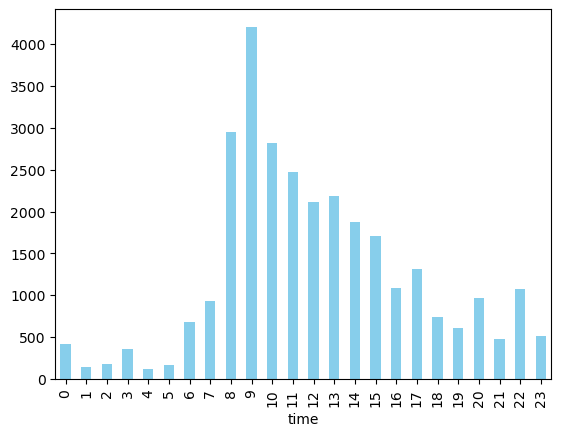

In [377]:
stock_date = stock_relation['time'].dt.hour.value_counts().sort_index()
stock_date.plot(kind='bar', color='skyblue')

In [378]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [379]:
def prepare_data(ticker, stock_relation):
    stock_price1 = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
    stock_price2 = pd.read_csv(f"../dataset/stocks/{ticker}_test.csv")
    stock_price = concat_df(stock_price1, stock_price2)
    
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()
    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    
    relation_t = stock_relation[stock_relation['ticker'] == ticker]
    relation_t['news_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
    relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)
    relation_t['direct_sentiment'] = relation_t['sentiment']
    relation_t.loc[relation_t['same_source'] == 0, 'direct_sentiment'] = 'None'

    news_comb = pd.merge(relation_t, stock_price, how='left', left_on='news_date', right_on='trade_date')
    # news_comb['trade_date'] = news_comb['trade_date'].fillna(method='bfill')
    news_comb = news_comb.dropna(subset=['trade_date'])
    news_comb['direct_sentiment'] = news_comb['sentiment']
    news_comb.loc[news_comb['source_ticker'] != news_comb['ticker'], 'direct_sentiment'] = 'None'

    relation_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first',
        'sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
        'direct_sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
    }).fillna(0.0).reset_index()
    relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'positive', 'negative', 'dir_positive', 'dir_negative']
    return relation_gp

In [380]:
relation_gp = prepare_data(ticker='META', stock_relation=stock_relation)
relation_gp_t = relation_gp[relation_gp['negative'] > 0]
len(relation_gp_t), len(relation_gp)

/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_4861/1254732481.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relation_t['news_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_4861/1254732481.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)
/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_4861/1254732481.p

(25, 99)

In [381]:
def test_relevance(cols):
    X, y = relation_gp_t[cols], relation_gp_t['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [382]:
test_relevance(['dir_negative', 'prv_close'])

(111.662015345827, 0.11372599886147938, array([16.44124053,  0.02759272]))

In [383]:
test_relevance(['negative', 'prv_close'])

(121.7496478943156, 0.03365932235492575, array([-3.50484316,  0.06807523]))

In [384]:
test_relevance(['dir_negative', 'negative', 'prv_close'])

(99.90288912893044,
 0.20705950900693526,
 array([ 27.8015961 , -14.55266776,   0.06803384]))

In [385]:
test_relevance(['dir_positive', 'prv_close'])

(117.39368819273459, 0.06823306546319607, array([-24.35345999,   0.03663794]))

In [386]:
test_relevance(['dir_negative', 'dir_positive', 'prv_close'])

(109.94643785759386,
 0.127342730746987,
 array([ 14.24005074, -14.57406121,   0.02076156]))

In [387]:
test_relevance(['dir_negative', 'negative', 'dir_positive', 'prv_close'])

(92.1217324568457,
 0.2688194265213737,
 array([ 26.46269386, -19.30934777, -33.45020898,   0.06557361]))

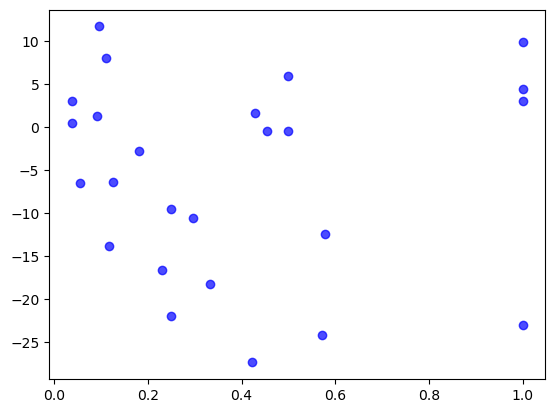

In [388]:
import matplotlib.pyplot as plt

plt.scatter(relation_gp_t['negative'], relation_gp_t['delta'], color='blue', alpha=0.7)

In [389]:
def preprocess(relation_gp):
    seq_length = 10
    std_scaler, max_scaler = StandardScaler(), MinMaxScaler()
    score_cols = ['dir_negative', 'negative', 'dir_positive']
    price_cols = ['close']

    df = pd.DataFrame()
    df[score_cols] = std_scaler.fit_transform(relation_gp[score_cols])
    df[price_cols] = max_scaler.fit_transform(relation_gp[price_cols])

    X = []
    y = []
    for i in range(seq_length, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = np.array(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) 

    return X_train, y_train, X_test, y_test

In [390]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [391]:
model = SimpleLSTM(input_size=4, hidden_size=64, output_size=1, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train, y_train, X_test, y_test = preprocess(relation_gp)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


(torch.Size([71, 10, 4]),
 torch.Size([71, 1]),
 torch.Size([18, 10, 4]),
 torch.Size([18, 1]))

In [392]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.5474
Epoch [2/100], Loss: 0.5264
Epoch [3/100], Loss: 0.5057
Epoch [4/100], Loss: 0.4853
Epoch [5/100], Loss: 0.4652
Epoch [6/100], Loss: 0.4454
Epoch [7/100], Loss: 0.4256
Epoch [8/100], Loss: 0.4059
Epoch [9/100], Loss: 0.3861
Epoch [10/100], Loss: 0.3661
Epoch [11/100], Loss: 0.3458
Epoch [12/100], Loss: 0.3251
Epoch [13/100], Loss: 0.3040
Epoch [14/100], Loss: 0.2823
Epoch [15/100], Loss: 0.2601
Epoch [16/100], Loss: 0.2372
Epoch [17/100], Loss: 0.2137
Epoch [18/100], Loss: 0.1896
Epoch [19/100], Loss: 0.1649
Epoch [20/100], Loss: 0.1400
Epoch [21/100], Loss: 0.1152
Epoch [22/100], Loss: 0.0912
Epoch [23/100], Loss: 0.0691
Epoch [24/100], Loss: 0.0508
Epoch [25/100], Loss: 0.0387
Epoch [26/100], Loss: 0.0359
Epoch [27/100], Loss: 0.0442
Epoch [28/100], Loss: 0.0593
Epoch [29/100], Loss: 0.0709
Epoch [30/100], Loss: 0.0725
Epoch [31/100], Loss: 0.0656
Epoch [32/100], Loss: 0.0550
Epoch [33/100], Loss: 0.0449
Epoch [34/100], Loss: 0.0377
Epoch [35/100], Loss: 0

In [393]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Test Loss: 0.0247
Std: 0.3015
Error Range: 0.5213
